# Simulation of skin wound geometries using a 2-layer, orthotropic hyperelastic model
Congzhou M Sha (ORCID: https://orcid.org/0000-0001-5301-9459, Email: cms6712@psu.edu)

Copyright © 2024

Please read the README!

### 0.1 Importing all the necessary libraries

In [1]:
# The familiar libraries
import numpy as np, matplotlib.pyplot as plt, os, gzip, pickle, tqdm

# MPI and PETSc
from mpi4py import MPI
from petsc4py import PETSc
# dolfinx
import dolfinx
import dolfinx.plot as plot
import dolfinx.fem.petsc
from dolfinx import fem, mesh, io, default_scalar_type, log
from dolfinx.fem import Function, functionspace, Constant
from dolfinx.mesh import meshtags, create_box, create_mesh, Mesh
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.io import gmshio
from dolfinx.graph import adjacencylist
from dolfinx.geometry import (bb_tree, compute_closest_entity, 
    create_midpoint_tree, squared_distance,
    compute_collisions_points, compute_colliding_cells)
from dolfinx.cpp.mesh import exterior_facet_indices

# ufl
from ufl import (Identity, grad, det, variable, tr, ln, diff,
    as_matrix, inner, exp, SpatialCoordinate, conditional, le,
    FacetNormal, inv, TrialFunctions, TestFunctions, dx, ds, Measure,
    lt, And, Or, sqrt, FiniteElement, VectorElement, TensorElement)

# Nonlinear solver
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl

# pyvista for visualization
import pyvista
pyvista.set_jupyter_backend('trame')

# We define geometries in './wound_geometries.py'
from wound_geometries import (linearScarMesh, cylindricalLinearScarMesh, curvedScarMesh, curvedWoundMesh, normal_skin_length,
    dermis_thickness, epidermis_thickness, subcutis_thickness, scar_thickness, scar_width)

# Define (some) model parameters
skin_thickness = dermis_thickness + epidermis_thickness + subcutis_thickness
lc = 0.05
skin_type = 'normal'
axis = np.array([0.5, np.sqrt(3) / 2, 0])
amplitude = 0
height_offset = 0.03
penalty_scale = 100

### 0.2 Defining useful utility functions

In [2]:
# Simple nonlinear solver
def simple_solve(Q, u, bcs, atol=1e-10, rtol=1e-10, relax=1, max_it=20, resume=None, keeplog=False):
    problem = NonlinearProblem(Q, u, bcs=bcs)
    if resume is not None:
        solver = resume
        resume.setJ(problem.J, resume._A)
        resume.setF(problem.F, resume._b)
        resume.set_form(problem.form)
    else:
        solver = NewtonSolver(MPI.COMM_WORLD, problem)
        solver.convergence_criterion = "incremental"
        solver.max_it = max_it
        solver.atol = atol
        solver.rtol = rtol
        solver.relaxation_parameter=relax
        solver.report = True
        ksp = solver.krylov_solver
        opts = PETSc.Options()
        option_prefix = ksp.getOptionsPrefix()
        opts[f"{option_prefix}ksp_type"] = "cg"
        opts[f"{option_prefix}pc_type"] = "gamg"
        opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
        ksp.setFromOptions()
    if keeplog:
        log.set_log_level(log.LogLevel.INFO)
    
    n, converged = solver.solve(u)
        
    log.set_log_level(log.LogLevel.OFF)
    return solver

# Interpolating a scalar
def interp_scalar(scalar, x, y, z):
    msh = scalar.function_space.mesh
    points = np.stack((x, y, z)).T
    bb_tree = dolfinx.geometry.bb_tree(msh, msh.topology.dim)
    # Find cells whose bounding-box collide with the the points
    cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, points)
    # Choose one of the cells that contains the point
    colliding_cells = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates, points)
    
    points_on_proc, cells = (*zip(*[(point, colliding_cells.links(i)[0]) \
        for (i, point) in enumerate(points) if len(colliding_cells.links(i)) > 0]),)
    points_on_proc, cells = np.stack(points_on_proc), np.stack(cells)
    return scalar.eval(points_on_proc, cells)

# Define plotting of geometry
def plot_geometry(msh):
    p = pyvista.Plotter()
    S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
    topology, cell_types, geometry = plot.vtk_mesh(S)
    u = Function(S)
    u.interpolate(lambda x: x[0] + x[1] + x[2])
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["u"] = u.x.array
    grid.set_active_scalars("u")
    actor_0 = p.add_mesh(grid, style="wireframe", color="k")
    actor_1 = p.add_mesh(grid, show_edges=False)
    p.show_axes()
    p.show()
    return p

def plot_deformed(u, factor=1, label_format='%.2f', number_labels=5, font_size_factor=1):
    p = pyvista.Plotter()
    topology, cell_types, geometry = plot.vtk_mesh(u.function_space)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(u)] = u.x.array.reshape((geometry.shape[0], 3))
    grid["u"] = values
    grid.set_active_vectors("u")
    actor_0 = p.add_mesh(grid, style="wireframe", color="k")
    warped = grid.warp_by_vector("u", factor=factor)
    warped.set_active_vectors("u")
    actor_1 = p.add_mesh(warped, show_edges=False)
    p.show_axes()
    p.show()
    return p

def add_rulers(p, bounds=None, geometry=None, label_format='%.2f', number_labels=5, font_size_factor=1):
    if bounds is not None:
        mins, maxs = bounds
    else:
        mins = np.min(geometry, axis=0)
        maxs = np.max(geometry, axis=0)
        
    p.add_ruler(mins, [maxs[0], mins[1], mins[2]], label_format=label_format, number_labels=number_labels, title='x', font_size_factor=font_size_factor)
    p.add_ruler(mins, [mins[0], maxs[1], mins[2]], label_format=label_format, number_labels=number_labels, title='y', font_size_factor=font_size_factor)
    p.add_ruler(mins, [mins[0], mins[1], maxs[2]], label_format=label_format, number_labels=number_labels, title='z', font_size_factor=font_size_factor)
    return p

def plot_scalar(scalar, name='scalar', logScale=True, label_format='%.2f', number_labels=5, font_size_factor=1):
    p = pyvista.Plotter()
    topology, cell_types, geometry = plot.vtk_mesh(scalar.function_space)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data[name] = np.log10(scalar.x.array) if logScale else scalar.x.array
    grid.set_active_scalars(name)
    actor_0 = p.add_mesh(grid)
    actor_1 = p.add_mesh(grid, style='wireframe', color="k")
    p.show_axes()
    p.show()
    return p

def plot_von_mises(msh, s_vm, logScale=False):
    S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
    vm = Function(S)
    vm.interpolate(fem.Expression(s_vm, S.element.interpolation_points()))
    return plot_scalar(vm, name='von Mises stress', logScale=logScale)

def plot_interpolation(scalars, x, y, z, xlabels=None, ylabels=None, figsize=None, plot=True):
    if not figsize: 
        N = int(np.sqrt(len(scalars)))
        figsize=(4.3 * N, 4 * N)
    if plot:
        fig, ax = plt.subplots(nrows=N, ncols=N, figsize=figsize, subplot_kw=dict(box_aspect=1))
    msh = scalars[0].function_space.mesh
    points = np.stack((x, y, z)).T
    bb_tree = dolfinx.geometry.bb_tree(msh, msh.topology.dim)
    # Find cells whose bounding-box collide with the the points
    cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, points)
    # Choose one of the cells that contains the point
    colliding_cells = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates, points)
    
    points_on_proc, cells = (*zip(*[(point, colliding_cells.links(i)[0]) \
        for (i, point) in enumerate(points) if len(colliding_cells.links(i)) > 0]),)
    points_on_proc, cells = np.stack(points_on_proc), np.stack(cells)
    interpolations = []
    for i in range(N):
        for j in range(N):
            index = i * N + j
            if index >= len(scalars):
                return interpolations
                
            interpolation = scalars[index].eval(points_on_proc, cells)
            interpolations.append(interpolation)
            if plot:
                ax[i,j].plot(x, interpolation)
                ax[i,j].axis()
                if xlabels:
                    ax[i,j].set_xlabel(xlabels[index])
                if ylabels:
                    ax[i,j].set_ylabel(ylabels[index])
    return interpolations

### 0.3 Constitutive model and variational form
Define the variational forms based on the constitutive model of the dermis/epidermis and subcutis. As described in the manuscript, we use a Mooney-Rivlin isotropic material for the subcutis and orthotropic Fung material for the dermis/epidermis.

In [3]:
pressure_scale = 1e-6
penalty_scale *= pressure_scale * 250_000

# Constitutive equations
def mooney_rivlin(F, J, c10=pressure_scale * default_scalar_type(400), c20=pressure_scale * default_scalar_type(1_400), K=pressure_scale * default_scalar_type(50_000)):
    F_tilde = variable((J ** -(1/3)) * F)
    B_tilde = variable(F_tilde * F_tilde.T)
    I1_bar = variable(tr(B_tilde))
    W = c10 * (I1_bar - 3.0) + c20 * (I1_bar - 3.0) ** 2.0 + K/2.0 * ln(J) * ln(J)
    return W

fung_params = {
    'normal': {'c': 21_300, 
               'mu_1': 17_800,
               'mu_2': 5_900,
               'mu_3': 5_900,
               'lambda_11': 1_000,
               'lambda_remaining': 1_000,
               'kappa': 250_000
              },
    'stiff': {'c': 42_600, 
           'mu_1': 35_600,
           'mu_2': 11_800,
           'mu_3': 11_800,
           'lambda_11': 11_800,
           'lambda_remaining': 2_000,
           'kappa': 250_000
          },
    'soft': {'c': 10_700, 
       'mu_1': 8_900,
       'mu_2': 3_000,
       'mu_3': 3_000,
       'lambda_11': 500,
       'lambda_remaining': 500,
       'kappa': 250_000
      }
}

fung_params = {k: {k2: v2 * pressure_scale for (k2, v2) in v.items()} for (k, v) in fung_params.items()}

fung_tsf = {'normal': 1.10, 'stiff': 1.05, 'soft': 1.15}

def self_outer_prod(a):
    return a[:, None] * a[None, :]

def fung(F, J, I, c, mu_1, mu_2, mu_3, kappa, lambda_11, lambda_remaining, a1=axis, a2=np.array([0, 0, 1]), regularize_fung=None):
    lambda_ab = lambda_remaining * np.ones((3, 3), dtype=default_scalar_type)
    lambda_ab[0, 0] = lambda_11
    mu = [mu_1, mu_2, mu_3]
    
    F_tilde = variable((J ** -(1/3)) * F)
    E_tilde = 0.5 * (F_tilde.T * F_tilde - I)
    E_tilde_square = E_tilde * E_tilde
    a3 = np.cross(a1, a2)
    A = [self_outer_prod(a1), self_outer_prod(a2), self_outer_prod(a3)]
    A = [as_matrix([[ufl.constantvalue.FloatValue(k) for k in j] for j in i]) for i in A]
    Q = 0
    for a in range(3):
        Q += 2 * mu[a] * inner(A[a], E_tilde_square)
        contraction1 = inner(A[a], E_tilde)
        for b in range(3):
            contraction2 = inner(A[b], E_tilde)
            Q += lambda_ab[a, b] * contraction1 * contraction2
    Q = Q / c
    expQ = exp(Q)
    if regularize_fung is not None:
        expQ = conditional(lt(Q, regularize_fung), expQ, np.exp(regularize_fung) * Q)
    W = 0.5 * c * (expQ - 1) + 0.5 * kappa * ln(J) * ln(J)
    return W

# Define the energy functional by automatically differentiating the energy functions
def functional(u, msh, subcutis_thickness, 
           dermis_thickness, 
           epidermis_thickness, 
           skin_type=skin_type, axis=axis, regularize_fung=None):
    x = SpatialCoordinate(msh)
    I = variable(Identity(3))
    F = variable(I + grad(u))
    J = variable(det(F))
    W_subcutis = mooney_rivlin(F, J)
    W_dermis = fung(F, J, I, **fung_params[skin_type], a1=axis, regularize_fung=regularize_fung)
    W = conditional(le(x[2], -dermis_thickness-epidermis_thickness), W_subcutis, W_dermis)
    return diff(W, F), F, J

# Helper function to define the von Mises stress, to be used in interpolating the final result
def von_mises(P, F, J):
    sigma = 1 / J * (F * P.T)
    s = sigma - tr(sigma) / 3 * Identity(3)
    s_vm = sqrt(1.5 * inner(s, s))
    return s_vm

# Create the variational form for the material potential energy, which we will seek to minimize
def constitutive_form(msh, subcutis_thickness, dermis_thickness, epidermis_thickness, skin_type=skin_type, axis=axis, order=1, epsilon=1e-4, regularize_fung=None):
    # Define the function space we wish to use
    v_el = ufl.VectorElement('Lagrange', msh.ufl_cell(), order)
    V = functionspace(msh, v_el)
    u = Function(V)
    eta = ufl.TestFunction(V)
    P, F, J = functional(u, msh, subcutis_thickness, dermis_thickness, epidermis_thickness, skin_type=skin_type, axis=axis, regularize_fung=regularize_fung)
    n = FacetNormal(msh)
    x = SpatialCoordinate(msh)
    dx = Measure('dx', domain=msh)
    Q = inner(P, grad(eta)) * dx
    return dict(Q=Q, u=u, eta=eta, F=F, s_vm=von_mises(P, F, J), J=J, P=P, V=V)

### 0.4 Creating various Dirichlet boundary conditions

In [4]:
def create_bcs(
    V, 
    skin_type, 
    normal_skin_length=normal_skin_length, 
    scar_width=scar_width, 
    skin_thickness=skin_thickness, 
    facet_tags=None, 
    intention_fraction=0.5, 
    intention_depth=0.5
):
    boundary_map = [(0, -normal_skin_length), (0, normal_skin_length + scar_width), (1, -normal_skin_length), (1, normal_skin_length), (2, -skin_thickness)]
    tsf = fung_tsf[skin_type]

    # Dirichlet BCs on the lateral exterior surfaces, enforcing the tension scaling factor
    def boundary_condition(dim, location):
        Vp, submap = V.sub(dim).collapse()
        boundary = lambda x: np.isclose(x[dim], location)
        boundary_facets = mesh.locate_entities_boundary(msh, 2, boundary)
        uD = Function(Vp)
        if dim == 2:
            uD.interpolate(lambda x: np.zeros_like(x[0]))
        else:
            uD.interpolate(lambda x: (tsf - 1) * x[dim])
        return fem.dirichletbc(
            uD, fem.locate_dofs_topological(
              (V.sub(dim), Vp), 2, boundary_facets),
            V.sub(dim))
    
    lateral_dirichlet_bcs = [boundary_condition(*i) for i in boundary_map]
    
    wall = lambda x: np.any(np.stack([np.isclose(x[dim], location) for (dim, location) in boundary_map]), axis=0)
    wall_facets = mesh.locate_entities_boundary(msh, 2, wall)
    
    sq_boundary_map = [(0, lambda x: x[0] * (tsf - 1)), (1, lambda x: x[1] * (tsf - 1)), (2, lambda x: np.zeros_like(x[1]))]

    # Dirichlet BCs on the bottom exterior surface, enforcing TSF as well as preventing vertical mobility (u_z = 0)
    def subcutis_boundaries(dir, displacement):
        subcutis_boundary = lambda x: np.isclose(x[2], -skin_thickness)
        subcutis_boundary_facets = mesh.locate_entities_boundary(msh, 2, subcutis_boundary)
        
        Vp, submap = V.sub(dir).collapse()
        uD = Function(Vp)
        uD.interpolate(displacement)
        return fem.dirichletbc(
            uD,
            fem.locate_dofs_topological(
              (V.sub(dir), Vp), 2, subcutis_boundary_facets),
            V.sub(dir))
    
    sub_cutis_bcs = [subcutis_boundaries(*i) for i in sq_boundary_map]

    # For use in the section on primary intention
    def primary_intention_bc():
        Vp, submap = V.sub(0).collapse()
        boundary_facets = facet_tags.find(4)

        # Filter depth of intention
        boundary = lambda x: x[2] > -intention_depth * scar_width / 2
        boundary_facets2 = set(mesh.locate_entities_boundary(msh, 2, boundary))
        boundary_facets = np.sort([i for i in boundary_facets if i in boundary_facets2])

        # Filter length of intention
        boundary = lambda x: (x[1] > -intention_fraction * normal_skin_length) & (x[1] < intention_fraction * normal_skin_length)
        boundary_facets2 = set(mesh.locate_entities_boundary(msh, 2, boundary))
        boundary_facets = np.sort([i for i in boundary_facets if i in boundary_facets2])
        
        uD = Function(Vp)
        uD.interpolate(lambda x: scar_width / 2 - x[0])
        return fem.dirichletbc(
            uD,
            fem.locate_dofs_topological(
                (V.sub(0), Vp), 2, boundary_facets),
            V.sub(0))
    if facet_tags:
        facet_tags = primary_intention_bc()
    return lateral_dirichlet_bcs, sub_cutis_bcs, facet_tags

## 1. Estimation of traction in healthy skin
We first convert the tension scaling factor (Dirichlet boundary conditions) into tractions which are normal (Neumann boundary conditions) to the lateral faces of the skin patch.

Since we have shown that the TSF results in uniform (lateral) expansion of the skin patch, we may directly calculate the result for a single cube of the given material.

### 1a. Subcutis traction
We first estimate the lateral traction for the isotropic subcutis. As expected, the isotropic subcutis results in the first Piola-Kirchoff tensor becoming diagonal, with $P_{xx}=P_{yy}$ and $P_{zz}=0$.

In [5]:
# Change this number to verify that the traction is independent of geometry
box_width = 1
# Change this number to verify that the traction is independent of finite element size
N_cells = 1
msh = create_box(MPI.COMM_WORLD, np.array([[-box_width, -box_width, -1], [box_width, box_width, 0]]), [N_cells, N_cells, N_cells])

# We set the dermis/epidermis thickness to 0, so that the entire domain is subcutis
Q, u, eta, F, s_vm, J, P, V = (*constitutive_form(msh, subcutis_thickness=1, dermis_thickness=0, epidermis_thickness=0).values(),)
lat_bc, sq_bc, _ = create_bcs(V, skin_type, normal_skin_length=box_width, scar_width=0, skin_thickness=1)
bcs = lat_bc# + sq_bc
simple_solve(Q, u, bcs)
p = plot_deformed(u, factor=1, font_size_factor=0.8, number_labels=5)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x285ded110_0&reconnect=auto' style='width: …

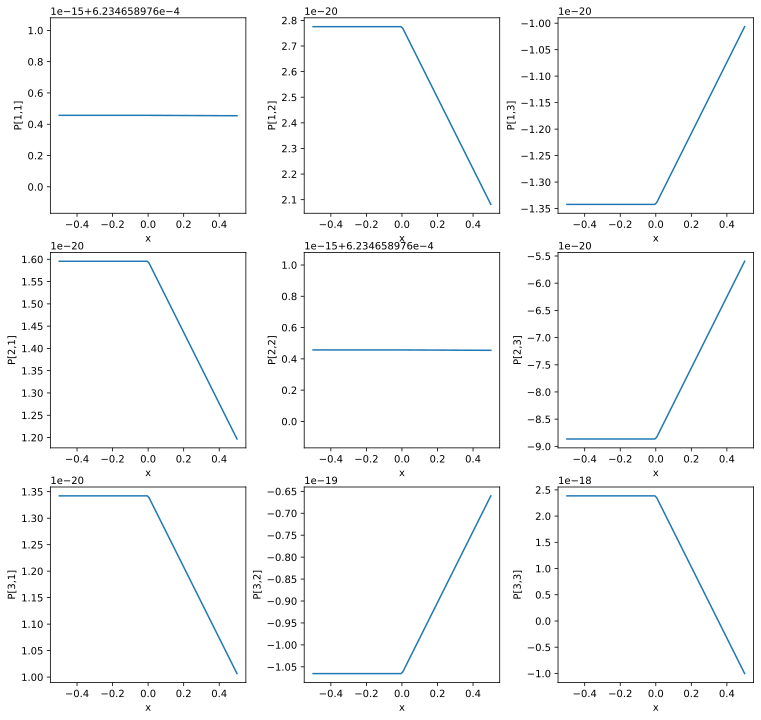

In [6]:
S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
tractions = [Function(S) for i in range(3) for j in range(3)]
_ = [tractions[i * 3 + j].interpolate(fem.Expression(P[i, j], S.element.interpolation_points())) for i in range(3) for j in range(3)]
x = np.linspace(-0.5, 0.5, 100)
y = np.zeros_like(x)
z = np.ones_like(x) * -0.5

# We interpolate the elements of the first Piola-Kirchhoff stress tensor along a line within the material
interps = plot_interpolation(tractions, x, y, z, xlabels=['x'] * 9, ylabels=[f'P[{i},{j}]' for i in range(1, 4) for j in range(1, 4)])

We find that there is a uniform traction on the subcutis along the outward-facing normals along the lateral boundaries, since only $P_{xx}$ and $P_{yy}$ are different from (numerical) zero. The magnitude of this traction is given below.

In [7]:
# Use the median on the interpolation of P[0,0] to guard against numerical errors
subcutis_lateral_traction = np.median(interps[0])
print(subcutis_lateral_traction)

0.000623465897606457


### 1b. Dermis/epidermis traction
The case for the dermis is complicated by the fact that the material is now orthotropic and thus we expect the traction to be dependent on the material axes. We can calculate this axial dependence directly because the healthy tissue is still translation-invariant, and thus the first Piola-Kircchoff stress $P$ is constant throughout the tissue.

The components of $P$ transform as $QP$ under a rigid body rotation $x\rightarrow Qx$, and the components of $\hat n$ transform as $Q^{-1}=Q^T\hat n$.

#### Create wound geometry and constitutive form

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x29481ff90_1&reconnect=auto' style='width: …

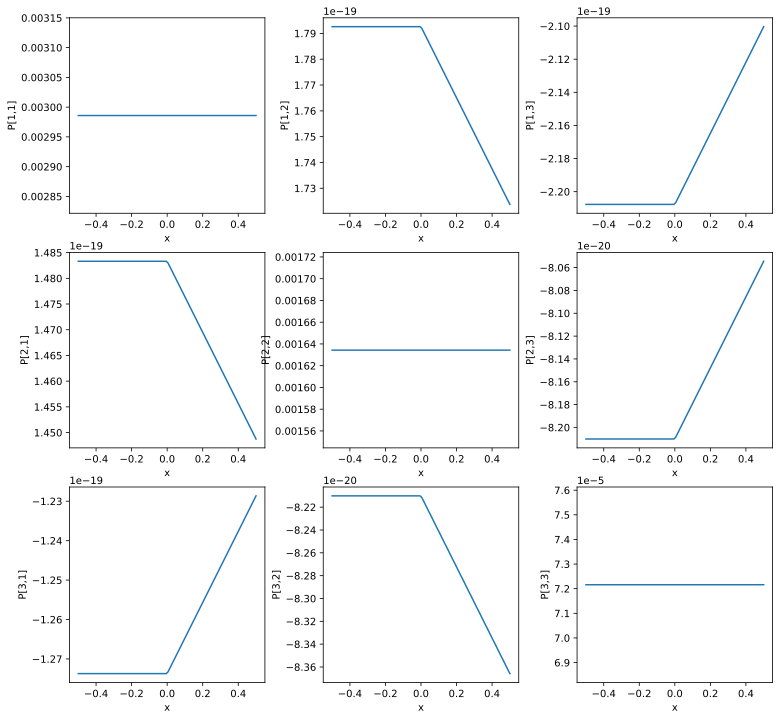

In [8]:
box_width = 1
msh = create_box(MPI.COMM_WORLD, np.array([[-box_width, -box_width, -1], [box_width, box_width, 0]]), [1, 1, 1])

theta = 0
def dermal_traction_dependence(theta, plot=True):
    axis = np.array([np.cos(theta), np.sin(theta), 0])
    
    # We set the dermis thickness to 1, so that the entire domain is dermis
    Q, u, eta, F, s_vm, J, P, V = (*constitutive_form(msh, subcutis_thickness=0, dermis_thickness=1, epidermis_thickness=0, axis=axis).values(),)
    lat_bc, sq_bc, _ = create_bcs(V, skin_type, normal_skin_length=box_width, scar_width=0, skin_thickness=1)
    bcs = lat_bc + sq_bc
    simple_solve(Q, u, bcs)
    if plot:
        plot_deformed(u)
    
    S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
    tractions = [Function(S) for i in range(3) for j in range(3)]
    _ = [tractions[i * 3 + j].interpolate(fem.Expression(P[i, j], S.element.interpolation_points())) for i in range(3) for j in range(3)]
    x = np.linspace(-0.5, 0.5, 100)
    y = np.zeros_like(x)
    z = np.ones_like(x) * -0.5
    
    # We interpolate the elements of the first Piola-Kirchhoff stress tensor along a line within the material
    interps = plot_interpolation(tractions, x, y, z, xlabels=['x'] * 9, ylabels=[f'P[{i},{j}]' for i in range(1, 4) for j in range(1, 4)], plot=plot)
    return interps

interps = dermal_traction_dependence(theta)

In [9]:
T = functionspace(msh, TensorElement('Lagrange', msh.ufl_cell(), 1, shape=(3,3)))
J_factor = Function(T)
J_factor.interpolate(fem.Expression(det(F) * inv(F).T, S.element.interpolation_points()))
x = np.linspace(-0.5, 0.5, 100)
y = np.zeros_like(x)
z = np.ones_like(x) * -0.5
J_factor_num = plot_interpolation([J_factor], x, y, z, plot=False)[0][50].reshape((3, 3))
a, b = (J_factor_num @ np.array([1, 0, 0])[:, None])[0,0], (J_factor_num @ np.array([0, 1, 0])[:, None])[1,0]

We can calculate the projections of $P$ along the $x$ and $y$ axes, to get the tractions along the boundaries at the highest values of $x$ and $y$. By symmetry, the tractions are negated on the remaining two boundaries.

In [10]:
def tractions(interps):
    t_x = np.array([np.median(interps[0]), np.median(interps[3]), 0])
    t_y = np.array([np.median(interps[1]), np.median(interps[4]), 0])
    return t_x, t_y
t_x, t_y = tractions(interps)
print(t_x, t_y)

[2.98589154e-03 1.48314064e-19 0.00000000e+00] [1.79224950e-19 1.63431487e-03 0.00000000e+00]


We now write down the analytic solution for the traction as a function of $\theta$. The material axis along $\hat z$ remains constant in all our simulations, so we ignore it.

In [11]:
def theoretical_traction(t_x, t_y, theta):
    # 2D (active) rotation in the xy-plane
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    ts = np.stack((t_x[:2], t_y[:2])).T
    ret = [np.concatenate((i, [0])) for i in (rotation @ ts @ rotation.T).T]
    return ret

We find excellent numerical agreement between the analytic and numerical solutions.

In [12]:
# Adjust this angle to verify that there is numerical agreement no matter material axis orientation
theta = np.pi / 3
# The analytic traction
tractions_analytic = theoretical_traction(t_x, t_y, theta)
# The numerical traction
tractions_numerical = tractions(dermal_traction_dependence(theta, plot=False))
print(tractions_analytic)
print(tractions_numerical)
assert np.allclose(np.stack(tractions_analytic), np.stack(tractions_numerical))

[array([0.00197221, 0.00058525, 0.        ]), array([0.00058525, 0.002648  , 0.        ])]
(array([0.00197221, 0.00058525, 0.        ]), array([0.00058525, 0.002648  , 0.        ]))


### 1c. Assemble the Neumann boundary conditions
We now replace all the boundary conditions with the analytically computed Neumann boundary conditions. Additionally, we need to fix a few degrees of freedom with Dirichlet boundary conditions.

(I): We use the analytical Neumann boundary conditions calculated above as a function of the material orientation, with the isotropic $P_{subcutis}$ and the orthotropic $P_{dermis}$. This is implemented in Part 1 of the function below.

(II): We fix the remaining unimportant translational and rotational degrees of freedom.
1. We assume that the base of the subcutis is fixed in the $z$ direction, that is $u_z=0$ for the 2D elements (facets) where $z=$-skin_thickness. In essence, we assume that the subcutis is firmly attached to underlying muscle, bone, or other tissue, and that the underlying tissue does not significant expand upward.
2. We locate a 0D element (a point) at the left ($x<0$) border of the domain, and we set its $u_x=0$, breaking the translational freedom in the x-direction.
3. We locate a 0D element (a point) at the right ($x>0$) border of the domain, and we set its $u_y=0$, breaking the translational freedom in the y-direction. Taken together, (2) and (3) also prevent rotation of the system.
 
The two dofs fixed in 2. and 3. are the exact minimum necessary to prevent rigid body movement in the $xy$ plane, and to ensure the resulting matrix is full rank. However, we will need to relax Newton's method to ensure convergence. We will first simply set a relaxation parameter, but later on we will apply additional regularization methods.

In [13]:
def tsf_neumann_bcs(t_subq, t_x_derm, t_y_derm, eta, theta, F,
       msh,
       V,
       orig_facet_tags,
       skin_type=skin_type,
       subcutis_thickness=subcutis_thickness, 
       dermis_thickness=dermis_thickness, 
       epidermis_thickness=epidermis_thickness,
       normal_skin_length=normal_skin_length,
       scar_width=scar_width):
    
    skin_thickness = subcutis_thickness + dermis_thickness + epidermis_thickness
    t_x_derm, t_y_derm = theoretical_traction(t_x_derm, t_y_derm, theta)
    
    # Part I: Dirichlet-to-Neumann mapping
    ############################################################################################
    # Neumann boundary conditions
    boundary_maps = [(0, -normal_skin_length), (0, normal_skin_length + scar_width), (1, normal_skin_length), (1, -normal_skin_length)]
    # Get all the exterior surfaces
    exterior_facets = mesh.locate_entities_boundary(msh, 2, lambda x: np.ones_like(x[0], dtype=bool))
    # Assign a tag for each surface
    facet_tags = {}
    for i, (dim, location) in enumerate(boundary_maps):
        boundary = lambda x: np.isclose(x[dim], location)
        boundary_facets = {j: i for j in mesh.locate_entities_boundary(msh, 2, boundary)}
        facet_tags.update(boundary_facets)
        
    facet_tags.update({j: len(boundary_maps) for j in orig_facet_tags.find(4)})
    '''
    exterior_set = set(exterior_facets)
    remaining_facets = set(i for i in exterior_set if i not in boundary_facets)
    # Assign a tag for the wound surface
    wound = lambda x: (~np.isclose(x[2], -skin_thickness)) & (~np.isclose(x[2], 0)) & (x[0] > 0) & (x[0] < scar_width)
    wound_facets = mesh.locate_entities_boundary(msh, 2, wound)
    wound_facets = np.sort([i for i in wound_facets if i not in remaining_facets])
    facet_tags.update({i: len(boundary_maps) for i in wound_facets})'''

    values = np.array([facet_tags[i] if i in facet_tags else -1 for i in exterior_facets], dtype=np.int32)
    facet_tags = dolfinx.mesh.meshtags(msh, 2, exterior_facets, values)

    # Custom surface measure
    ds = Measure('ds', domain=msh, subdomain_data=facet_tags)
    n = FacetNormal(msh)
    
    subcutis_depth = -(epidermis_thickness + dermis_thickness)
    subq_derm_conditional = lambda a, b: conditional(lt(x[2], subcutis_depth), a, b)
    
    forms = []
    for i, (dim, location) in enumerate(boundary_maps):
        derm_term = t_x_derm if dim == 0 else t_y_derm
        derm_term = ufl.as_vector(derm_term)
        for j in range(3):
            forms.append(-subq_derm_conditional(t_subq * n[j], derm_term[j]) * eta[j] * ds(i))
        
    tsf = fung_tsf[skin_type]

    # Part II: Remaining Dirichlet boundary conditions
    ############################################################################################

    # 1. we fix the bottom of the subcutis surface so that there is 
    subcutis_loc = lambda x: np.isclose(x[2], -skin_thickness)
    subcutis_boundary = mesh.locate_entities_boundary(msh, dim, subcutis_loc)
    subcutis_boundary_facets = mesh.locate_entities_boundary(msh, 2, subcutis_loc)
    '''d_bcs = [fem.dirichletbc(np.array([0,0,0], dtype=default_scalar_type), 
                        fem.locate_dofs_topological(
                            V, 2, subcutis_boundary_facets), 
                        V)]

    '''
    V2, _ = V.sub(2).collapse()
    uD = Function(V2)
    uD.interpolate(lambda x: np.zeros_like(x[0]))
    d_bcs = [fem.dirichletbc(uD, 
                        fem.locate_dofs_topological(
                            (V.sub(2), V2), 2, subcutis_boundary_facets), 
                        V.sub(2))]
    
    dim_trans = 0
    dim_rot = 0
    num2fix = 1

    # 2. The first 0D entity will break the x-translation symmetry of the system
    subcutis_boundary = mesh.locate_entities_boundary(msh, dim_trans, subcutis_loc)
    dists1 = squared_distance(msh, dim_trans, subcutis_boundary,
            np.repeat(np.array([[-normal_skin_length, 0, -skin_thickness]]), len(subcutis_boundary), axis=0))
    closest1 = np.argsort(dists1)
    entity1 = subcutis_boundary[closest1[:num2fix]]

    V0, _ = V.sub(0).collapse()
    uD = Function(V0)
    uD.interpolate(lambda x: np.zeros_like(x[0]))
    d_bcs.append(fem.dirichletbc(uD, 
                        fem.locate_dofs_topological(
                            (V.sub(0), V0), dim_rot, entity1), 
                        V.sub(0)))

    # 3. The second 1D entity will break the 2D rotation symmetry of the system
    subcutis_boundary = mesh.locate_entities_boundary(msh, dim_rot, subcutis_loc)
    dists2 = squared_distance(msh, dim_rot, subcutis_boundary,
            np.repeat(np.array([[normal_skin_length + scar_width, 0, -skin_thickness]]), len(subcutis_boundary), axis=0))
    closest2 = np.argsort(dists2)
    entity2 = subcutis_boundary[closest2[:num2fix]]
    
    V1, _ = V.sub(1).collapse()
    uD = Function(V1)
    uD.interpolate(lambda x: np.zeros_like(x[0]))
    d_bcs.append(fem.dirichletbc(uD, 
                        fem.locate_dofs_topological(
                            (V.sub(1), V1), dim_rot, entity2), 
                        V.sub(1)))
    
    return sum(forms), d_bcs, facet_tags

Here, we visualize the result of imposing the above boundary conditions on healthy skin.

In [14]:
theta = np.pi / 6
axis = np.array([np.cos(theta), np.sin(theta), 0])

skin_thickness = dermis_thickness + epidermis_thickness + subcutis_thickness
msh, cell_tags, facet_tags = linearScarMesh(normal_skin_length=normal_skin_length, \
                epidermis_thickness=epidermis_thickness,
                dermis_thickness=dermis_thickness,
                subcutis_thickness=subcutis_thickness,
                scar_width=scar_width,
                scar_height=normal_skin_length,
                scar_thickness=scar_thickness, \
                lc=0.1)

Q, u, eta, F, s_vm, J, P, V = (*constitutive_form(msh, subcutis_thickness, dermis_thickness, epidermis_thickness, axis=axis, order=1).values(),)

form_bcs, d_bcs, new_facet_tags = tsf_neumann_bcs(
    subcutis_lateral_traction, 
    t_x, 
    t_y, 
    eta, 
    theta, 
    F, 
    msh,
    V,
    facet_tags,
    skin_type=skin_type,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    normal_skin_length=normal_skin_length,
    scar_width=scar_width
)

Info    : Clearing all models and views...
Info    : Done clearing all models and views


In [15]:
if not os.path.exists('cache/D2N.npy'):
    try:
        r = simple_solve(Q + form_bcs, u, bcs=d_bcs, relax=0.5, max_it=5)
    except:
        simple_solve(Q + form_bcs, u, bcs=d_bcs)
    np.save('cache/D2N.npy', u.x.array)
else:
    u.x.array[:] = np.load('cache/D2N.npy')

First, we examine the von Mises stress to check that the two layers (the dermis/epidermis vs subcutis) are each uniformly stressed.

In [16]:
plot_von_mises(msh, s_vm, logScale=True)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x2998c8e10_2&reconnect=auto' style='width: …

Next, we visualize the final deformed domain to verify that there has been uniform expansion.

In [17]:
plot_deformed(u)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x285c9e690_3&reconnect=auto' style='width: …

While there are clear finite size effects at work, we see that qualitatively the results of the Dirichlet boundary conditions for tension scaling are reproduced with the replacement Neumann/Dirichlet BCs. The finite size effects should decrease with smaller mesh size/higher order elements.

## 2. Primary intention
In this section, we explain how to model primary intention in the skin. We begin with the simple case of a wound with reflection symmetry.

### 2.1 Reflection symmetry determines the Dirichlet BC in primary intention
When the wound possesses a planar symmetry in its geometry and total energy, we expect that the two sides of the wound will meet in the middle at static equilibrium. We start with the cylindrical wound, with $xy$ material axes parallel or perpendicular to the wound major axis.

In [18]:
epidermis_thickness = 0
dermis_thickness = 2e-3
subcutis_thickness = 5e-3
scar_width = 7e-3
height_offset = 0
normal_skin_length = 20e-3
lc = 10e-4
meshSizeMin = 0.2
meshSizeMax = 3
meshSizeCurvature = 40
min_lc = lc * meshSizeMin
skin_thickness = subcutis_thickness+dermis_thickness+epidermis_thickness
print(dermis_thickness, subcutis_thickness, scar_width, skin_thickness, normal_skin_length)

msh, cell_tags, facet_tags = curvedWoundMesh(
    amplitude=amplitude,
    height_offset=height_offset,
    scar_width=scar_width,
    normal_skin_length=normal_skin_length,
    start=-normal_skin_length,
    stop=normal_skin_length,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    lc=lc,
    meshSizeCurvature=meshSizeCurvature,
    meshSizeMin=meshSizeMin,
    meshSizeMax=meshSizeMax)
plot_geometry(msh)

0.002 0.005 0.007 0.007 0.02
[(3, 1), (3, 2)]
[(3, 1), (3, 2)]
[(3, 1)]


Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x285c9d610_4&reconnect=auto' style='width: …

We define the constitutive variational form as usual. For boundary conditions, we will enforce $u_z=0$ for the base of the subcutis (bottom surface), and enforce the primary intention boundary condition in the middle of the scar, setting $u_x=\frac12$scar_width$-x$ for all the wound facets, where $x$ is the position of a given facet. For the lateral boundary conditions, we will apply Note that `facet_tags` must be supplied as an argument to `create_bcs`, where a tag value of $4$ marks the wound facets, i.e. `facet_tags.find(4)` returns the indices of those 2-simplices.

In [19]:
theta = 0
axis = np.array([np.cos(theta), np.sin(theta), 0])
Q, u, eta, F, s_vm, J, P, V = (*constitutive_form(msh, subcutis_thickness, dermis_thickness, epidermis_thickness, axis=axis, order=1).values(),)

lateral_bcs, subcutis_bcs, p_bc = create_bcs(
    V, skin_type, 
    normal_skin_length=normal_skin_length, 
    scar_width=scar_width, 
    skin_thickness=skin_thickness, 
    facet_tags=facet_tags
)

form_bcs, d_bcs, new_facet_tags = tsf_neumann_bcs(
    subcutis_lateral_traction,
    t_x, 
    t_y, 
    eta, 
    theta, 
    F, 
    msh,
    V,
    facet_tags,
    skin_type=skin_type,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    normal_skin_length=normal_skin_length,
    scar_width=scar_width         
)

In [20]:
fn = 'cache/primary_intention_1.npy'
try:
    u.vector.setArray(np.load(fn))
except:
    try:
        simple_solve(Q, u, bcs=lateral_bcs + d_bcs + [p_bc], relax=0.1, max_it=10)
    except:
        try:
            simple_solve(Q + form_bcs, u, bcs=d_bcs + [p_bc], relax=0.1, max_it=10)
        except:
            simple_solve(Q + form_bcs, u, bcs=d_bcs + [p_bc])
            np.save(fn, u.x.array)

In [21]:
plot_deformed(u)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x285d88090_5&reconnect=auto' style='width: …

In [22]:
plot_von_mises(msh, s_vm, logScale=True)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x2a1de41d0_6&reconnect=auto' style='width: …

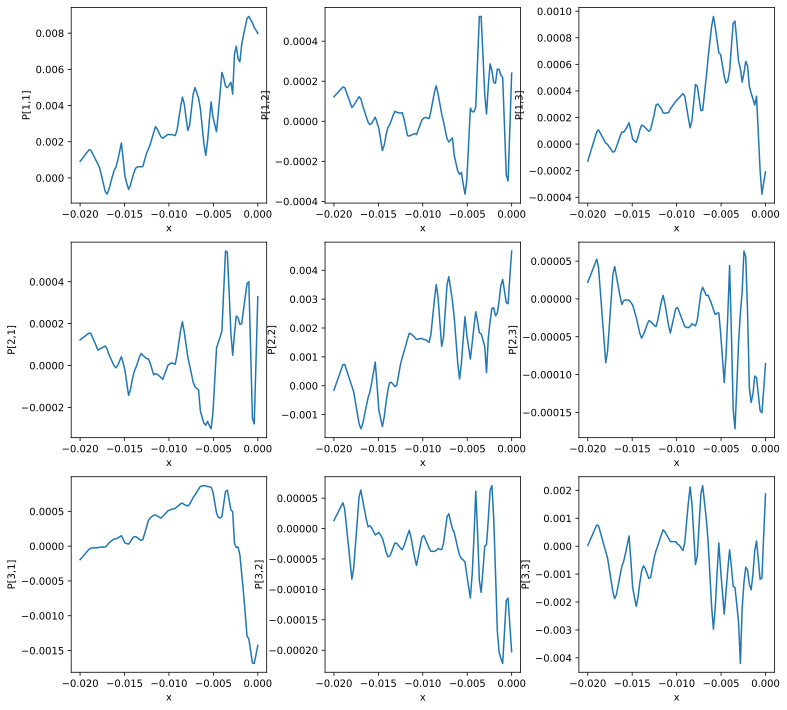

In [23]:
S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
tractions = [Function(S) for i in range(3) for j in range(3)]
_ = [tractions[i * 3 + j].interpolate(fem.Expression(P[i, j], S.element.interpolation_points())) for i in range(3) for j in range(3)]
x = np.linspace(-normal_skin_length, 0, 100)
y = np.zeros_like(y)
z = np.ones_like(x) * -1e-10

# We interpolate the elements of the first Piola-Kirchhoff stress tensor along a line within the material
interps = plot_interpolation(tractions, x, y, z, xlabels=['x'] * 9, ylabels=[f'P[{i},{j}]' for i in range(1, 4) for j in range(1, 4)])

Now, we try to reproduce these results using Neumann boundary conditions. From the above plots, we can calculate a rough estimate for the magnitude of the traction. Note that we have not yet accounted for contact forces.

In [24]:
def primary_intention_neumann(
    mag, msh, eta, facet_tags, 
    intention_depth=0.5,
    intention_fraction=0.5,
    scar_width=scar_width, 
    normal_skin_length=normal_skin_length
):
    n = FacetNormal(msh)
    x = SpatialCoordinate(msh)
    ds = Measure('ds', domain=msh, subdomain_data=facet_tags)
    intention_limit = intention_fraction * normal_skin_length
    intention_height_cond = And(lt(x[1], intention_limit), lt(-intention_limit, x[1]))
    
    intention_depth_cond = lt(-intention_depth * scar_width / 2, x[2])
    return conditional(And(intention_depth_cond, intention_height_cond), -mag * n[0] * eta[0], 0) * ds(4)

In [25]:
traction_mag = np.max(interps[0]) * 1.3
p_bc_form = primary_intention_neumann(traction_mag, msh, eta, new_facet_tags)

In [26]:
fn = 'cache/primary_intention_2.npy'
n_steps = 10
try:
    u.vector.setArray(np.load(fn))
except:
    r = None
    try:
        r = simple_solve(Q + form_bcs + p_bc_form, u, bcs=d_bcs, relax=0.2, max_it=5, resume=r)
    except:
        pass
    r = simple_solve(Q + form_bcs + p_bc_form, u, bcs=d_bcs, relax=1, max_it=100, resume=r)
    np.save(fn, u.x.array)

In [27]:
plot_deformed(u)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x299850e10_7&reconnect=auto' style='width: …

In [28]:
plot_von_mises(msh, s_vm, logScale=True)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x2ad3312d0_8&reconnect=auto' style='width: …

## 3. Calculating contacts
1. Find the displacement $d$ from each interpolation point within the reference body to the nearest exterior facet.
2. Using Nanson's formula ($\hat n\propto F^{-T}\hat N$), calculate the pushforward ($F^{-T}$) of the deformation.
3. Use the pushforward to transform $d$, with normalization.

In [29]:
# Set up wound mesh
theta = np.pi / 6
axis = np.array([np.cos(theta), np.sin(theta), 0])
epidermis_thickness = 0
dermis_thickness = 2e-3
subcutis_thickness = 5e-3
scar_width = 7e-3
height_offset = 0
normal_skin_length = 20e-3
lc = 10e-4
meshSizeMin = 0.2
meshSizeMax = 3
meshSizeCurvature = 40
min_lc = lc * meshSizeMin
skin_thickness = subcutis_thickness + dermis_thickness + epidermis_thickness
print(dermis_thickness, subcutis_thickness, scar_width, skin_thickness, normal_skin_length)

# And deformed mesh, so that we can calculate the material depth gradient
def_msh, _, _ = curvedWoundMesh(
    amplitude=amplitude,
    height_offset=height_offset,
    scar_width=scar_width,
    normal_skin_length=normal_skin_length,
    start=-normal_skin_length,
    stop=normal_skin_length,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    lc=lc,
    meshSizeCurvature=meshSizeCurvature,
    meshSizeMin=meshSizeMin,
    meshSizeMax=meshSizeMax)

msh, cell_tags, facet_tags = curvedWoundMesh(
    amplitude=amplitude,
    height_offset=height_offset,
    scar_width=scar_width,
    normal_skin_length=normal_skin_length,
    start=-normal_skin_length,
    stop=normal_skin_length,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    lc=lc,
    meshSizeCurvature=meshSizeCurvature,
    meshSizeMin=meshSizeMin,
    meshSizeMax=meshSizeMax)

Q, u, eta, F, s_vm, J, P, V = (*constitutive_form(
    msh, 
    subcutis_thickness, 
    dermis_thickness, 
    epidermis_thickness, 
    axis=axis, 
    regularize_fung=-2.0).values(),)

plot_geometry(msh)

0.002 0.005 0.007 0.007 0.02
[(3, 1), (3, 2)]
[(3, 1), (3, 2)]
[(3, 1)]
[(3, 1), (3, 2)]
[(3, 1), (3, 2)]
[(3, 1)]


Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x29990a590_9&reconnect=auto' style='width: …

We will perform solving in stages, to ensure convergence:

1. Tension scaling using Dirichlet boundary conditions
2. Tension scaling using Neumann boundary conditions
3. Primary intention using Dirichlet boundary conditions
4. Primary intention using Neumann boundary conditions
5. Contact model using material depth gradient

In [30]:
##################################################
# Stage 1: tension scaling using Dirichlet BCs
##################################################
relax=0.2
relax_it=1
p_bc_scale=1.3
form_bcs, d_bcs, new_facet_tags = tsf_neumann_bcs(
    subcutis_lateral_traction,
    t_x, 
    t_y, 
    eta, 
    theta,
    F, 
    msh,
    V,
    facet_tags,
    skin_type=skin_type,
    subcutis_thickness=subcutis_thickness, 
    dermis_thickness=dermis_thickness, 
    epidermis_thickness=epidermis_thickness,
    normal_skin_length=normal_skin_length,
    scar_width=scar_width       
)

lat_bcs, sq_bcs, p_bc = create_bcs(
    V, 
    skin_type, 
    normal_skin_length=normal_skin_length, 
    scar_width=scar_width, 
    skin_thickness=skin_thickness, 
    facet_tags=new_facet_tags,
    intention_fraction=0.5, 
    intention_depth=0.7
)

In [31]:
import sys
def fire_min(Q, u, bcs, fn=None, atol=1e-10, relax=1e-3, relax_it=relax_it, max_it=30, factor=1.5, min_lc=min_lc, lc=3 * min_lc, r=None, callbacks=[], keeplog=True, finalSolve=False):
    if fn is not None and os.path.exists(fn):
        u.vector.setArray(np.load(fn))
        return

    if len(callbacks) > 0:
        max_it = relax_it * max_it
        relax_it = 1
    
    previous_u = np.copy(u.x.array)
    prev_du = np.zeros_like(previous_u)
    i = 0
    while relax < 1 and i < max_it:
        i += 1
        print('Iteration:', i, 'relaxation:', relax, end=' ')
        log.set_log_level(log.LogLevel.OFF)
        for (func, arg) in callbacks:
            func(arg)
        sys.stdout.flush()
        try:
            r = simple_solve(Q, u, bcs, relax=relax, max_it=relax_it, resume=r, keeplog=keeplog)
            break
        except:
            pass
            
        du = np.abs(u.x.array - previous_u)
        if np.all(prev_du == du):
            print('Diverged!')
            break
        prev_du = du
        m = np.max(du)
        print('max du:', m, 'sum du:', np.sum(du), end=' ')
        if np.sum(du) < atol:
            break
        if m < min_lc:
            print('too small')
            if relax < 1 / factor:
                relax *= factor
            previous_u[:] = u.x.array
        elif m > lc:
            print('too large')
            if relax > 1e-10:
                relax /= (factor * factor)
            else:
                print('Ill-conditioned!')
                break

            if np.allclose(u.x.array, previous_u):
                print('Ill-conditioned!')
                break
            u.x.array[:] = previous_u

    if finalSolve:
        for (func, arg) in callbacks:
            func(arg)
        r = simple_solve(Q, u, bcs, resume=r)
    if fn is not None:
        np.save(fn, u.x.array)
    return r

In [32]:
if not os.path.exists('cache/stage1.npy'):
    fire_min(Q, u, bcs=lat_bcs + sq_bcs, max_it=50, atol=1e-12, keeplog=True)
    np.save('cache/stage1.npy', u.x.array)
else:
    u.vector.setArray(np.load('cache/stage1.npy'))

In [33]:
##################################################
# Stage 2: tension scaling using Neumann BCs,
# combined with primary intention Dirichlet
##################################################
if os.path.exists('cache/stage2.npy'):
    u.vector.setArray(np.load('cache/stage2.npy'))
else:
    fire_min(Q + form_bcs, u, d_bcs + [p_bc], fn='cache/stage2.npy', relax_it=0.01, max_it=50)

In [34]:
plot_deformed(u)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x2999270d0_10&reconnect=auto' style='width:…

In [35]:
plot_von_mises(msh, s_vm, logScale=True)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x29992b4d0_11&reconnect=auto' style='width:…

In [36]:
##################################################
# Stage 3: tension scaling using Neumann BCs,
# combined with primary intention Neumann
##################################################
log.set_log_level(log.LogLevel.OFF)
S = functionspace(msh, FiniteElement('Lagrange', msh.ufl_cell(), 1))
traction = Function(S)
traction.interpolate(fem.Expression(P[0, 0], S.element.interpolation_points()))
x = np.linspace(-normal_skin_length, 0, 100)
y = np.zeros_like(y)
z = np.ones_like(x) * -1e-10

traction_mag = np.max(np.abs(interp_scalar(traction, x, y, z))) * p_bc_scale

p_bc_form = 1.4 * primary_intention_neumann(traction_mag, msh, eta, new_facet_tags, intention_depth=2.0)
if os.path.exists('cache/stage3.npy'):
    u.vector.setArray(np.load('cache/stage3.npy'))
else:
    fire_min(Q + form_bcs + p_bc_form, u, max_it=50, bcs=d_bcs, fn='cache/stage3.npy')

In [37]:
plot_deformed(u)

Widget(value="<iframe src='http://localhost:60350/index.html?ui=P_0x299817d50_12&reconnect=auto' style='width:…

In [38]:
origPositions = np.copy(msh.geometry.x[:, :])
ref_bbtree = bb_tree(msh, 3)
cell_candidates = compute_collisions_points(ref_bbtree, origPositions)
colliding_cells = compute_colliding_cells(msh, cell_candidates, origPositions)
colliding_cells = np.array([colliding_cells.links(i)[0] for i in range(len(origPositions))], dtype=np.int32)

def update_def_msh(msh=msh, def_msh=def_msh, u=u, colliding_cells=colliding_cells, origPositions=origPositions):
    def_msh.geometry.x[:, :] = msh.geometry.x[:, :] + u.eval(origPositions, colliding_cells)

material_disp = Function(V)
exterior_facets = mesh.locate_entities_boundary(msh, 2, lambda x: np.ones_like(x[0], dtype=bool))

# Calculate the displacement to the nearest exterior facet
def calculate_depth_vector(x, msh=def_msh):
    x = x.T
    bbtree = bb_tree(msh, 2, exterior_facets)
    midtree = create_midpoint_tree(msh, 2, exterior_facets)
    closest_ind = compute_closest_entity(bbtree, midtree, msh, x)
    points = msh.geometry.x
    closest = dolfinx.cpp.mesh.entities_to_geometry(msh._cpp_object, 2, closest_ind, orient=False)
    # Get the centers of each facet
    closest = np.mean(points[closest], axis=-2)
    # Get grad
    disp = x - closest
    disp = disp / np.linalg.norm(disp + 1e-32, axis=-1, keepdims=True)
    return disp.T
    
material_disp.interpolate(calculate_depth_vector)

# Get the value of the material normal in the deformed configuration
# Points is (N, 3)
V_def = functionspace(def_msh, ufl.VectorElement('Lagrange', def_msh.ufl_cell(), 1))
pos = Function(V)
pos.interpolate(lambda x: x)
pushforward = Function(V)

dphi_mat_disp = J * inv(F).T * material_disp
dphi_mat_disp = fem.Expression(dphi_mat_disp, V.element.interpolation_points())
f_dphi_mat_disp = Function(V)

V_def = functionspace(def_msh, ufl.VectorElement('Lagrange', def_msh.ufl_cell(), 1))
f_dphi_mat_disp_def = Function(V_def)

def_pos = Function(V_def)
def_pos.interpolate(lambda x: x)

ref_bbtree = bb_tree(msh, 3)
ref_cell_candidates = None
ref_colliding_cells = None

# Set these values beforehand
def collision_set_vals(points):
    global ref_cell_candidates, ref_colliding_cells
    points = points.T
    ref_cell_candidates = compute_collisions_points(ref_bbtree, points)
    ref_colliding_cells = compute_colliding_cells(msh, ref_cell_candidates, points)
    ref_colliding_cells = [set(ref_colliding_cells.links(i)) for i in range(len(points))]
    return points.T

pushforward.interpolate(collision_set_vals)

ref_cells = [list(i)[0] if len(i) > 0  else -1 for i in ref_colliding_cells]

def collision(points, dphi_mat_disp=dphi_mat_disp, f_dphi_mat_disp=f_dphi_mat_disp, f_dphi_mat_disp_def=f_dphi_mat_disp_def,
           material_disp=material_disp, F=F, 
           msh=msh, def_msh=def_msh, 
           ref_colliding_cells=ref_colliding_cells):
    
    # The points are in the reference configuration (msh)
    points = points.T
    origPoints = points
    # Transform the points to the deformed configuration (def_msh) by adding u
    phi = u.eval(points, ref_cells)
    points = points + phi
    
    # Update the deformed mesh, interpolate the pushforward of dphi
    update_def_msh()
    f_dphi_mat_disp.interpolate(dphi_mat_disp)
    f_dphi_mat_disp_def.x.array[:] = f_dphi_mat_disp.x.array

    # Get the collision tree in the deformed mesh
    bbtree = bb_tree(def_msh, 3)

    # Compute the new collisions in the deformed mesh
    cell_candidates = compute_collisions_points(bbtree, points)
    colliding_cells = compute_colliding_cells(def_msh, cell_candidates, points)
    colliding_cells = [colliding_cells.links(i) for i in range(len(points))]

    # Get all valid collisions
    cell_diff = [np.array([k for k in i if k not in j], dtype=np.int32) for (i, j) in zip(colliding_cells, ref_colliding_cells)]

    # Find the indices of those cells which are colliding
    is_colliding = [i[squared_distance(def_msh, 3, i, np.repeat(j[None, :], len(i), axis=0)) < 1e-16] for (i, j) in zip(cell_diff, points)]
    # Ignore multiple collisions
    cells = np.array([i[0] if len(i) > 0 else -1 for i in is_colliding], dtype=np.int32)
    print(np.count_nonzero(cells > 0), 'collisions detected')
    
    # If no collision, we set the material normal to zero
    cell_pos = cells > 0
    res = f_dphi_mat_disp_def.eval(points, cells)
    collision_mat_disp = np.where(cell_pos[:, None], res, 0)
    #collision_mat_disp = np.where(cell_pos[:, None], res, 0) / lc
    return collision_mat_disp.T

def calculate_depth(x, msh=msh):
    x = x.T
    bbtree = bb_tree(msh, 2, exterior_facets)
    midtree = create_midpoint_tree(msh, 2, exterior_facets)
    closest_ind = compute_closest_entity(bbtree, midtree, msh, x)
    dist = squared_distance(msh, 2, closest_ind, x)
    return dist

S = functionspace(msh, ufl.FiniteElement('Lagrange', msh.ufl_cell(), 1))
material_depth = Function(S)
material_depth.interpolate(calculate_depth)

gN = Function(S)

S_def = functionspace(def_msh, ufl.FiniteElement('Lagrange', def_msh.ufl_cell(), 1))
material_depth_def = Function(S_def)
material_depth_def.x.array[:] = material_depth.x.array

def collision_depth(points, u=u,
           material_depth_def=material_depth_def, F=F, 
           msh=msh, def_msh=def_msh, 
           ref_colliding_cells=ref_colliding_cells):
    
    # The points are in the reference configuration (msh)
    points = points.T
    origPoints = points
    # Transform the points to the deformed configuration (def_msh) by adding u
    phi = u.eval(points, ref_cells)
    points = points + phi
    
    update_def_msh()
    # Get the collision tree in the deformed mesh
    bbtree = bb_tree(def_msh, 3)

    # Compute the new collisions in the deformed mesh
    cell_candidates = compute_collisions_points(bbtree, points)
    colliding_cells = compute_colliding_cells(def_msh, cell_candidates, points)
    colliding_cells = [colliding_cells.links(i) for i in range(len(points))]

    # Get all valid collisions
    cell_diff = [np.array([k for k in i if k not in j], dtype=np.int32) for (i, j) in zip(colliding_cells, ref_colliding_cells)]

    # Find the indices of those cells which are colliding
    is_colliding = [i[squared_distance(def_msh, 3, i, np.repeat(j[None, :], len(i), axis=0)) < 1e-16] for (i, j) in zip(cell_diff, points)]
    # Ignore multiple collisions
    cells = np.array([i[0] if len(i) > 0 else -1 for i in is_colliding], dtype=np.int32)
    
    # If no collision, we set the material normal to zero
    cell_pos = cells > 0
    res = material_depth_def.eval(points, cells)
    collision_mat_disp = np.where(cell_pos, res[:, 0], 0)
    print(np.count_nonzero(cell_pos), 'collisions')
    return collision_mat_disp
    
gN.interpolate(collision_depth)

penalty_form = 1e3 * inner(grad(exp(gN)), eta) * Measure('dx', domain=msh)

1717 collisions


In [39]:
u.vector.setArray(np.load('cache/stage1.npy'))
if os.path.exists('cache/stage4.npy'):
    u.vector.setArray(np.load('cache/stage4.npy'))
else:
    fire_min(Q + form_bcs + p_bc_form + penalty_form, u, bcs=d_bcs, 
             fn='cache/stage4.npy', callbacks=[(gN.interpolate, collision_depth)], 
             finalSolve=False, max_it=50, relax_it=1)